<a href="https://colab.research.google.com/github/muhammad-madridista/IntroductionToPytorch/blob/main/AnimalsImageClassificationKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadmadridista98
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:06<00:00, 107MB/s]


In [3]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cpu


In [4]:
image_path=[]
labels=[]

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)
data_df=pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
print(data_df["labels"].unique())
data_df.head()

['wild' 'cat' 'dog']


,image_path,labels
0,/content/animal-faces/afhq/train/wild/flickr_w...,wild
1,/content/animal-faces/afhq/train/wild/flickr_w...,wild
2,/content/animal-faces/afhq/train/wild/flickr_w...,wild
3,/content/animal-faces/afhq/train/wild/flickr_w...,wild
4,/content/animal-faces/afhq/train/wild/flickr_w...,wild


In [5]:
train=data_df.sample(frac=0.7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5)
test=test.drop(val.index)

print("Train shape: ",train.shape)
print("Test shape: ",test.shape)
print("Val shape: ",val.shape)

Train shape:  (11291, 2)
Test shape:  (2419, 2)
Val shape:  (2420, 2)


In [6]:
label_encoder=LabelEncoder()
label_encoder.fit(train["labels"])


transform=transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


In [7]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform=None):
    self.dataframe=dataframe
    self.transform=transform
    self.labels=torch.tensor(label_encoder.transform(dataframe["labels"])).to(device)

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self,idx):
    image_path=self.dataframe.iloc[idx,0]
    label=self.labels[idx]
    image=Image.open(image_path).convert('RGB')

    if self.transform:
      image=self.transform(image).to(device)

    return image,label



In [8]:
train_dataset= CustomImageDataset(dataframe=train,transform=transform)
test_dataset= CustomImageDataset(dataframe=test,transform=transform)
val_dataset= CustomImageDataset(dataframe=val,transform=transform)

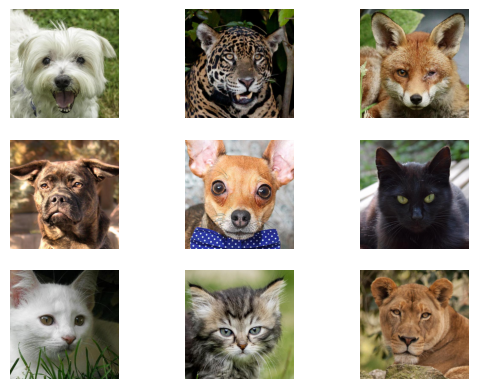

In [9]:
n_rows=3
n_cols=3

f,axarr=plt.subplots(n_rows,n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image_path = data_df.sample(n=1)["image_path"].iloc[0]
    image = Image.open(image_path).convert("RGB")
    axarr[row,col].imshow(image)
    axarr[row,col].axis('off')

plt.show()

In [10]:
  LR=1e-4
  BATCH_SIZE=16
  EPOCHS=10


In [11]:
train_loader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [12]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)
    self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1)
    self.conv3=nn.Conv2d(64,128,kernel_size=3,padding=1)

    self.pooling=nn.MaxPool2d(2,2)
    self.relu=nn.ReLU()
    self.flatten=nn.Flatten()
    self.linear=nn.Linear((128*16*16),128)
    self.output=nn.Linear(128,len(data_df["labels"].unique()))

  def forward(self,x):
    x=self.relu(self.conv1(x)) # (32,128,128)
    x=self.pooling(x) # (32,64,64)
    x=self.relu(self.conv2(x)) # (64,64,64)
    x=self.pooling(x) # (64,32,32)
    x=self.relu(self.conv3(x)) # (128,32,32)
    x=self.pooling(x) # (128,16,16)
    x=self.flatten(x) # (2048)
    x=self.relu(self.linear(x)) # (128)
    x=self.output(x) # (12)
    return x



In [13]:
model=Net().to(device)

In [14]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-2         [-1, 32, 128, 128]               0
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
              ReLU-8          [-1, 128, 32, 32]               0
         MaxPool2d-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
             ReLU-12                  [-1, 128]               0
           Linear-13                    [-1, 3]             387
Total params: 4,288,067
Trainable param

In [15]:
criterion= nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=LR)


In [16]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []


for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))
  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
  print("="*25)


Epoch 1/10, Train Loss: 4.499 Train Accuracy 71.7828
              Validation Loss: 0.5273 Validation Accuracy: 87.7273
Epoch 2/10, Train Loss: 2.085 Train Accuracy 88.5838
              Validation Loss: 0.4114 Validation Accuracy: 90.0
Epoch 3/10, Train Loss: 1.5566 Train Accuracy 91.8696
              Validation Loss: 0.3128 Validation Accuracy: 92.6033
Epoch 4/10, Train Loss: 1.2064 Train Accuracy 93.8978
              Validation Loss: 0.3706 Validation Accuracy: 90.5785
Epoch 5/10, Train Loss: 0.9661 Train Accuracy 95.2263
              Validation Loss: 0.2458 Validation Accuracy: 94.2562
Epoch 6/10, Train Loss: 0.7998 Train Accuracy 95.9348
              Validation Loss: 0.236 Validation Accuracy: 94.0496
Epoch 7/10, Train Loss: 0.6587 Train Accuracy 96.6965
              Validation Loss: 0.1982 Validation Accuracy: 94.9587
Epoch 8/10, Train Loss: 0.5349 Train Accuracy 97.405
              Validation Loss: 0.22 Validation Accuracy: 94.5868
Epoch 9/10, Train Loss: 0.4411 Train Accu

In [17]:
with  torch.no_grad():
  total_acc_test = 0
  total_loss_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)
    acc=(torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test+=acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")


Accuracy Score is: 94.9566 and Loss is 0.0222


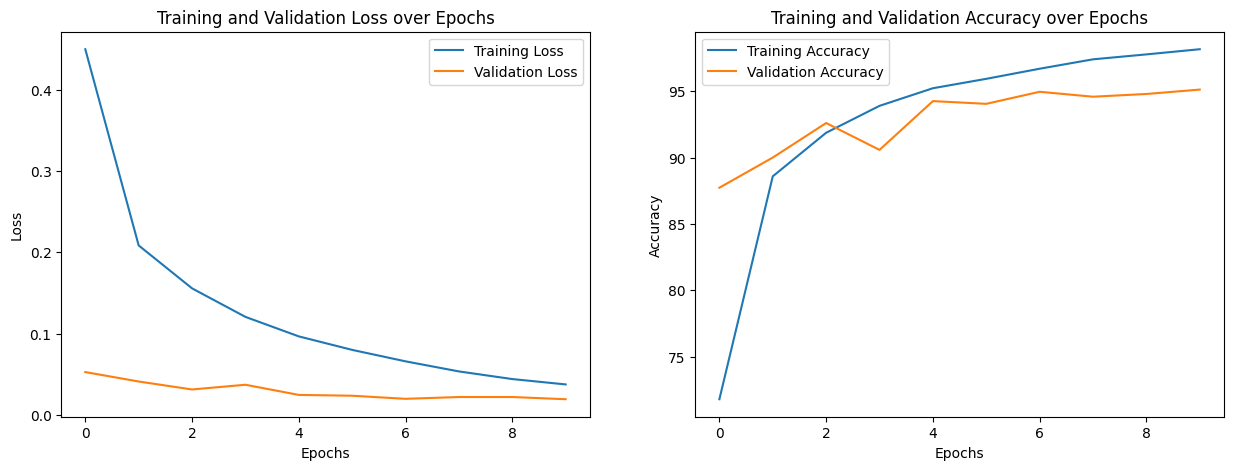

In [18]:
fig, axs=plt.subplots(nrows=1,ncols=2,figsize=(15,5))
axs[0].plot(total_loss_train_plot,label='Training Loss')
axs[0].plot(total_loss_validation_plot,label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Training Accuracy')
axs[1].plot(total_acc_validation_plot,label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [33]:
#1- Read the image
#2- Transform using transform object
#3- Predict through the model
#4- Inverse transform by label encoder

def predict_image(image_path):
  image=Image.open(image_path).convert('RGB')
  image=transform(image).to(device)
  #print(image.unsqueeze(0).shape)
  #print(image.shape)
  output=model(image.unsqueeze(0))
  output=torch.argmax(output,axis=1)
  return label_encoder.inverse_transform(output.cpu())[0]
  return output



In [34]:
predict_image('/content/animal-faces/afhq/train/wild/flickr_wild_000002.jpg')

'wild'